In [21]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import distance_metric, type_metric
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns
dataf = pd.read_csv('../DATASET/Hasil_Gabungan.csv')

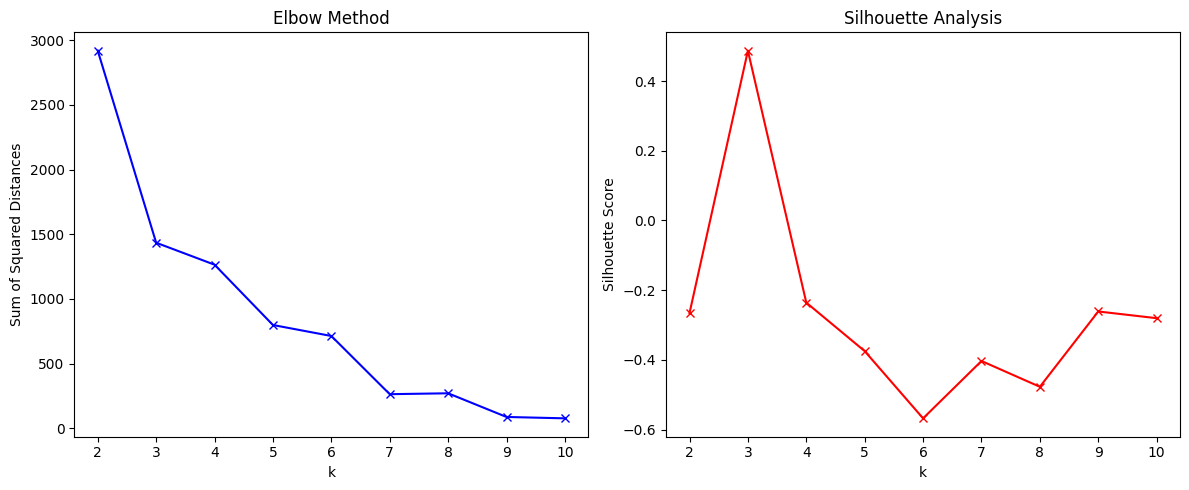

In [22]:
featuress = [
    'Residential_2021', 'Industrial_2021', 'Business_2021', 'Social_2021', 'Gov_Office_2021', 
    'Pub_Street_2021', 'Total_2021', 'Residential_2022', 'Industrial_2022', 'Business_2022', 
    'Social_2022', 'Gov_Office_2022', 'Pub_Street_2022', 'Total_2022', 'Residential', 
    'Industrial', 'Business', 'Social', 'Gov_Office', 'Pub_Street', 'Total', 
    'JP_2021', 'JP_2022', 'JP_2023', 'KP_2021', 'KP_2022', 'KP_2023'
]

dataS = dataf[featuress]
dataS['Provinsi'] = dataf['Province']

scaler = RobustScaler()
dataS_scaled = scaler.fit_transform(dataS[featuress])

def find_best_k(X, max_k=10):
    inertias = [] 
    silhouettes = []  
    K = range(2, max_k + 1)

    for k in K:
        initial_medoids = np.random.choice(range(X.shape[0]), size=k, replace=False).tolist()
        kmedoids_model = kmedoids(X, initial_medoids, metric=distance_metric(type_metric.EUCLIDEAN))
        kmedoids_model.process()

        clusters = kmedoids_model.get_clusters()
        inertia = 0
        for cluster_idx in clusters:
            medoid = X[cluster_idx[0]] 
            inertia += np.sum(np.linalg.norm(X[cluster_idx] - medoid, axis=1) ** 2)  
        silhouette_avg = silhouette_score(X, np.concatenate([np.full(len(cluster), idx) for idx, cluster in enumerate(clusters)]))
        
        inertias.append(inertia)
        silhouettes.append(silhouette_avg)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method')

    plt.subplot(1, 2, 2)
    plt.plot(K, silhouettes, 'rx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')

    plt.tight_layout()
    plt.show()

find_best_k(dataS_scaled, max_k=10)




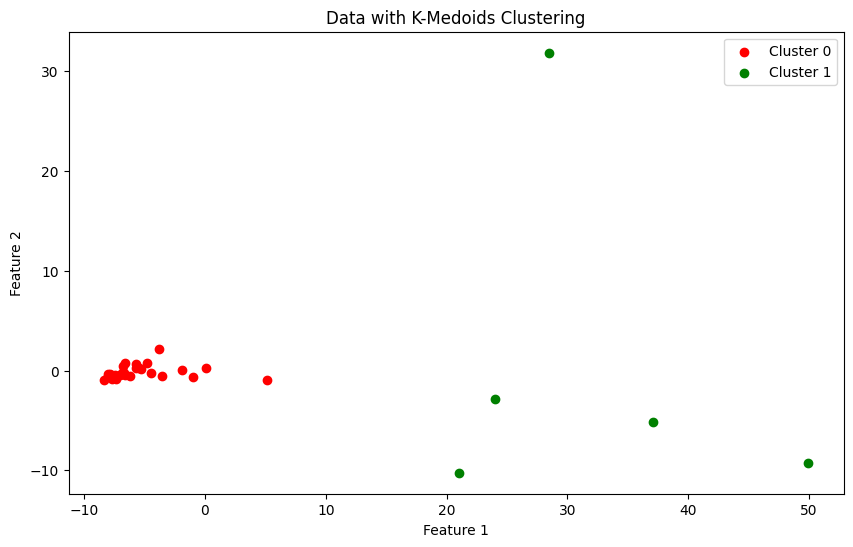

Provinsi dalam Klaster 0:
Aceh
Sumatera Utara
Sumatera Barat
Riau
Kep. Riau
Sumatera Selatan
Jambi
Bengkulu
Kep. Bangka Belitung
Lampung
Kalimantan Barat
Kalimantan Selatan
Kalimantan Tengah
Sulawesi Utara
Gorontalo
Sulawesi Tengah
Sulawesi Selatan
Sulawesi Tenggara
Sulawesi Barat
Maluku
Maluku Utara
Papua
Papua Barat
Bali
Nusa Tenggara Barat
Nusa Tenggara Timur
DI Yogyakarta
Kalimantan Timur
Kalimantan Utara
Provinsi dalam Klaster 1:
Jawa Timur
Jawa Tengah
Jawa Barat
Banten
DKI Jakarta


In [31]:
optimal_k = 2 
initial_medoids = np.random.choice(range(dataS_scaled.shape[0]), size=optimal_k, replace=False).tolist()


kmedoids_model = kmedoids(dataS_scaled, initial_medoids, metric=distance_metric(type_metric.EUCLIDEAN))
kmedoids_model.process()

clusters = kmedoids_model.get_clusters()

def plot_data(X, clusters):
    plt.figure(figsize=(10, 6))
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)

    colors = ['r', 'g']
    for i, cluster in enumerate(clusters):
        cluster_data = X[cluster]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], color=colors[i % len(colors)], label=f'Cluster {i}')
       
    plt.title('Data with K-Medoids Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_data(dataS_scaled, clusters)
for i, cluster in enumerate(clusters):
    print(f"Provinsi dalam Klaster {i}:")
    for idx in cluster:
        print(dataS['Provinsi'].iloc[idx])


In [24]:
features1 = ['Residential_2021', 'Business_2021', 'Industrial_2021', 'Social_2021', 'Gov_Office_2021', 'Pub_Street_2021', 'Total_2021', 'JP_2021', 'KP_2021']
np.random.seed(42)  
data_T2021 = dataf[features1]
scaler = RobustScaler()
scaled_features = scaler.fit_transform(data_T2021)

k = 3
medoid = np.random.choice(len(scaled_features), size=k, replace=False)
medoids = scaled_features[medoid]

def update_medoids(dataf, medoids):
    distances = pairwise_distances(dataf, medoids)
    labels = np.argmin(distances, axis=1)

    new_medoids = []
    for i in range(k):
        cluster_points = dataf[labels == i]
        intra_distances = pairwise_distances(cluster_points)
        min_index = np.argmin(intra_distances.sum(axis=1))
        new_medoids.append(cluster_points[min_index])
    
    return np.array(new_medoids), labels

for _ in range(len(scaled_features)):  
    new_medoids, labels = update_medoids(scaled_features, medoids)
    if np.allclose(new_medoids, medoids):
        break
    medoids = new_medoids

dataf['Cluster'] = labels

provinsi_per_cluster = dataf[['Province', 'Cluster']].sort_values(by='Cluster')


for cluster in range(k):  
    print(f"Provinsi dalam Cluster {cluster}:")
    print(provinsi_per_cluster[provinsi_per_cluster['Cluster'] == cluster]['Province'].tolist())

    print(f"Nilai data point (medoid) untuk Cluster {cluster}:")
    print(medoids[cluster])  
    print("\n")

Provinsi dalam Cluster 0:
['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Sumatera Selatan', 'Kalimantan Selatan', 'Kalimantan Barat', 'Lampung', 'Bali', 'DI Yogyakarta', 'Sulawesi Selatan', 'Kalimantan Timur']
Nilai data point (medoid) untuk Cluster 0:
[0.15035157 0.07410664 0.70550435 0.46523604 0.07352771 0.43682512
 0.3307586  0.23425846 0.31909934]


Provinsi dalam Cluster 1:
['Kalimantan Tengah', 'Jambi', 'Kep. Riau', 'Bengkulu', 'Sulawesi Tengah', 'Gorontalo', 'Sulawesi Utara', 'Sulawesi Barat', 'Maluku', 'Maluku Utara', 'Papua', 'Sulawesi Tenggara', 'Papua Barat', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 'Kep. Bangka Belitung', 'Kalimantan Utara']
Nilai data point (medoid) untuk Cluster 1:
[-0.29767405 -0.34488025 -0.16771017 -0.28138875 -0.49167793 -0.30482153
 -0.24842276 -0.2721861  -0.25403665]


Provinsi dalam Cluster 2:
['Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'DKI Jakarta', 'Banten']
Nilai data point (medoid) untuk Cluster 2:
[ 6.27825292  5.21211718 16.006

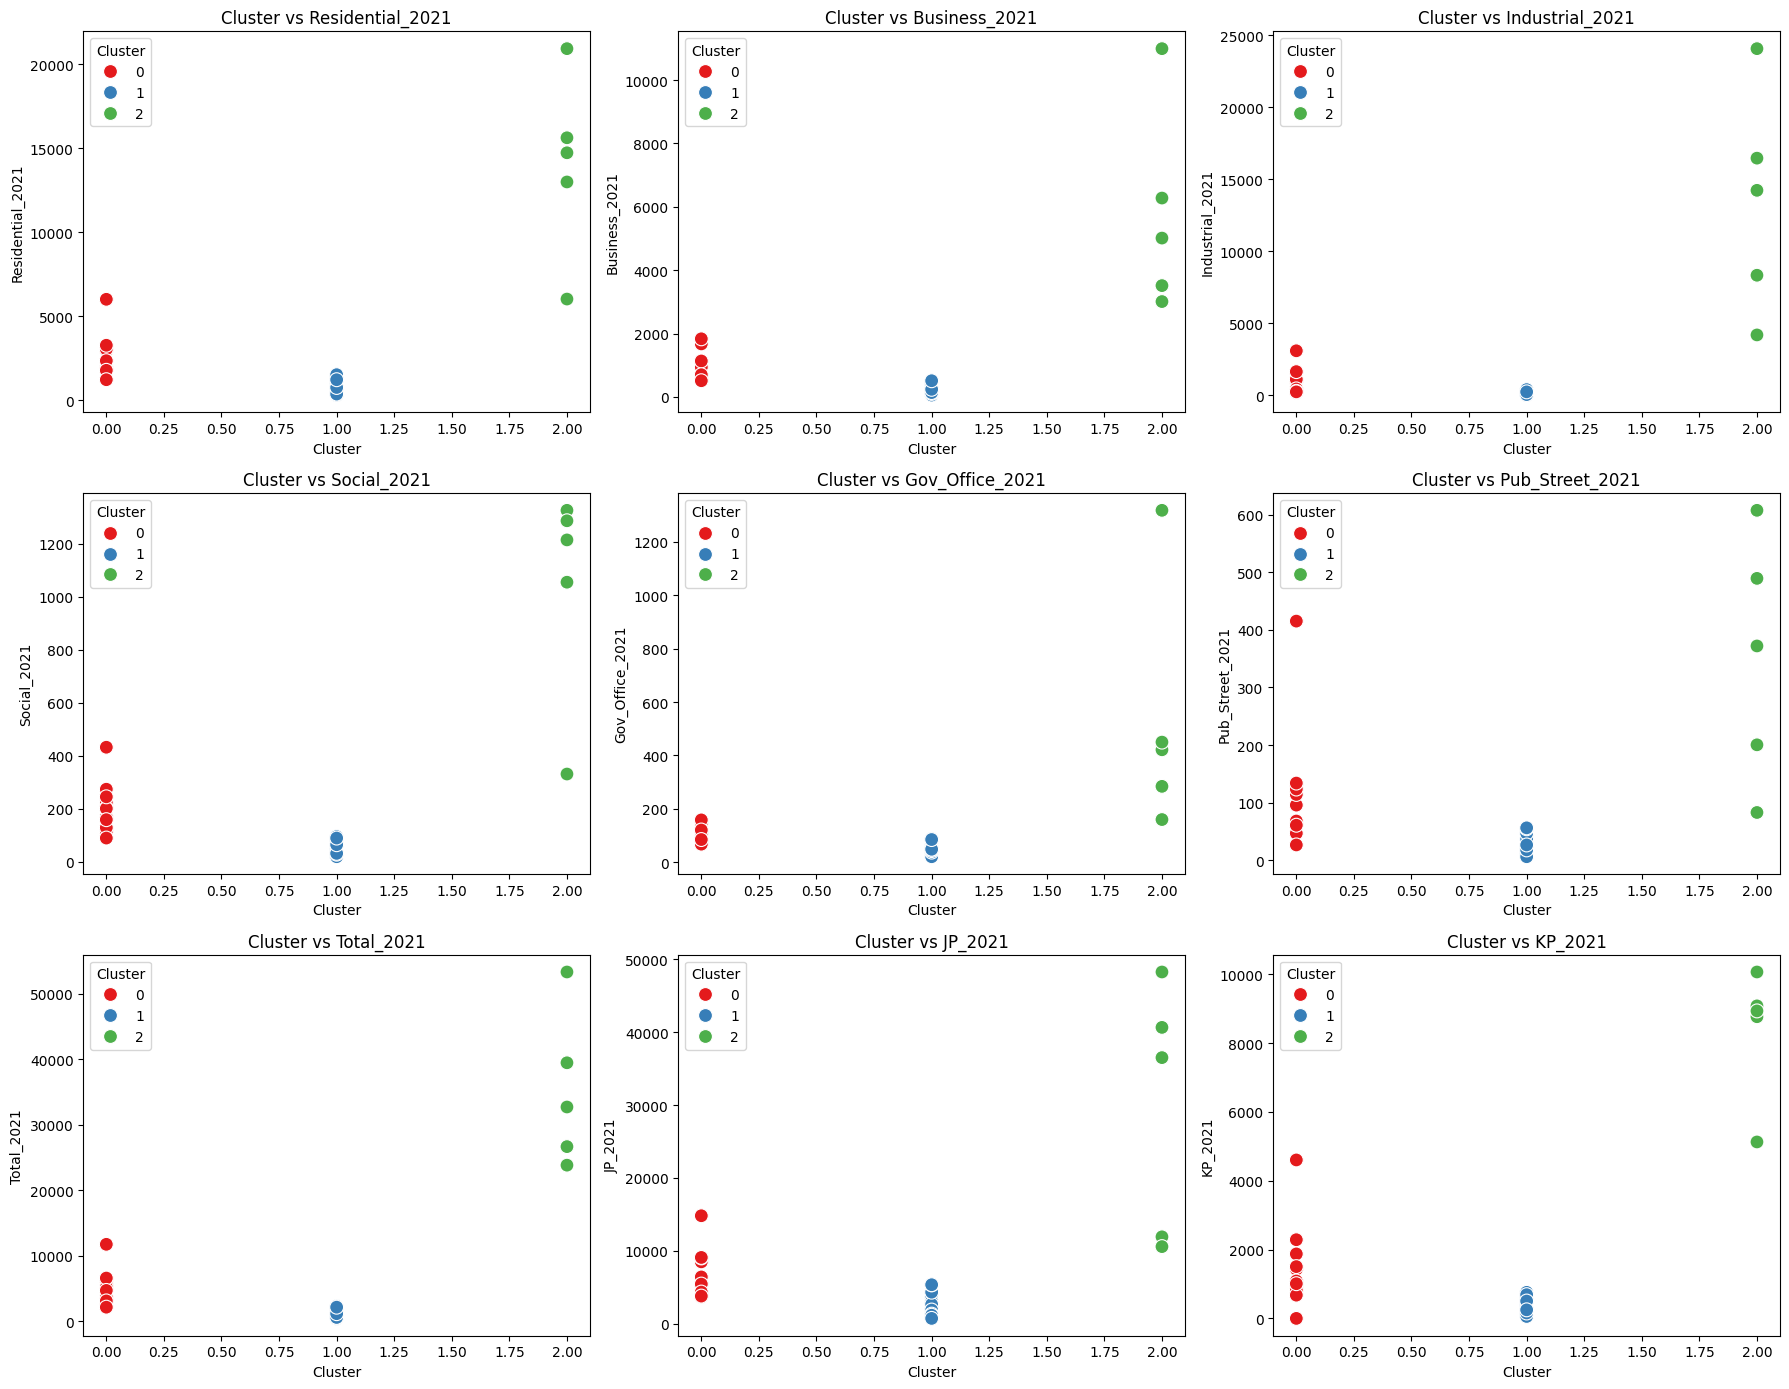

In [25]:
plt.figure(figsize=(18, 14))  

for i, feature in enumerate(features1, 1):
    plt.subplot(3, 3, i)  
    sns.scatterplot(x='Cluster', y=feature, data=dataf, hue='Cluster', palette='Set1', s=100)
    plt.title(f'Cluster vs {feature}')
    plt.xlabel('Cluster')
    plt.ylabel(f'{feature}')

plt.tight_layout()
plt.show()

In [26]:
features2 = ['Residential_2022', 'Business_2022', 'Industrial_2022', 'Social_2022', 'Gov_Office_2022', 'Pub_Street_2022', 'Total_2022', 'JP_2022', 'KP_2022']
np.random.seed(42)
data_T2022 = dataf[features2]

scaler2 = RobustScaler()
scaled_features2 = scaler2.fit_transform(data_T2022)


k =3
medoid2 = np.random.choice(len(scaled_features2), size=k, replace=False)
medoids2 = scaled_features2[medoid2]

def update_medoids(dataf, medoids2):
    distances = pairwise_distances(dataf, medoids2)
    labels2 = np.argmin(distances, axis=1)

    new_medoids2 = []
    for i in range(k):
        cluster_points2 = dataf[labels2 == i]
        intra_distances2 = pairwise_distances(cluster_points2)
        min_index2 = np.argmin(intra_distances2.sum(axis=1))
        new_medoids2.append(cluster_points2[min_index2])
    
    return np.array(new_medoids2), labels2

for _ in range(len(scaled_features2)):  
    new_medoids2, labels2 = update_medoids(scaled_features2, medoids2)
    if np.allclose(new_medoids2, medoids2):
        break
    medoids2 = new_medoids2

dataf['Cluster2'] = labels2

provinsi_per_cluster = dataf[['Province', 'Cluster2']].sort_values(by='Cluster2')


for cluster in range(k):  
    print(f"Provinsi dalam Cluster2 {cluster}:")
    print(provinsi_per_cluster[provinsi_per_cluster['Cluster2'] == cluster]['Province'].tolist())

    print(f"Nilai data point (medoid) untuk Cluster2 {cluster}:")
    print(medoids2[cluster])  
    print("\n")

Provinsi dalam Cluster2 0:
['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Sumatera Selatan', 'Kalimantan Selatan', 'Kalimantan Barat', 'Lampung', 'Bali', 'DI Yogyakarta', 'Sulawesi Selatan', 'Kalimantan Timur']
Nilai data point (medoid) untuk Cluster2 0:
[0.14639378 0.0999871  0.55817925 0.43026486 0.05200928 0.4957694
 0.29278643 0.33990739 0.16219907]


Provinsi dalam Cluster2 1:
['Kalimantan Tengah', 'Jambi', 'Kep. Riau', 'Bengkulu', 'Sulawesi Tengah', 'Gorontalo', 'Sulawesi Utara', 'Sulawesi Barat', 'Maluku', 'Maluku Utara', 'Papua', 'Sulawesi Tenggara', 'Papua Barat', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 'Kep. Bangka Belitung', 'Kalimantan Utara']
Nilai data point (medoid) untuk Cluster2 1:
[-0.29249717 -0.33798252 -0.14884191 -0.27472893 -0.50579782 -0.24613987
 -0.23880919 -0.39040308 -0.41032799]


Provinsi dalam Cluster2 2:
['Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'DKI Jakarta', 'Banten']
Nilai data point (medoid) untuk Cluster2 2:
[ 6.16110003  5.27641975 1

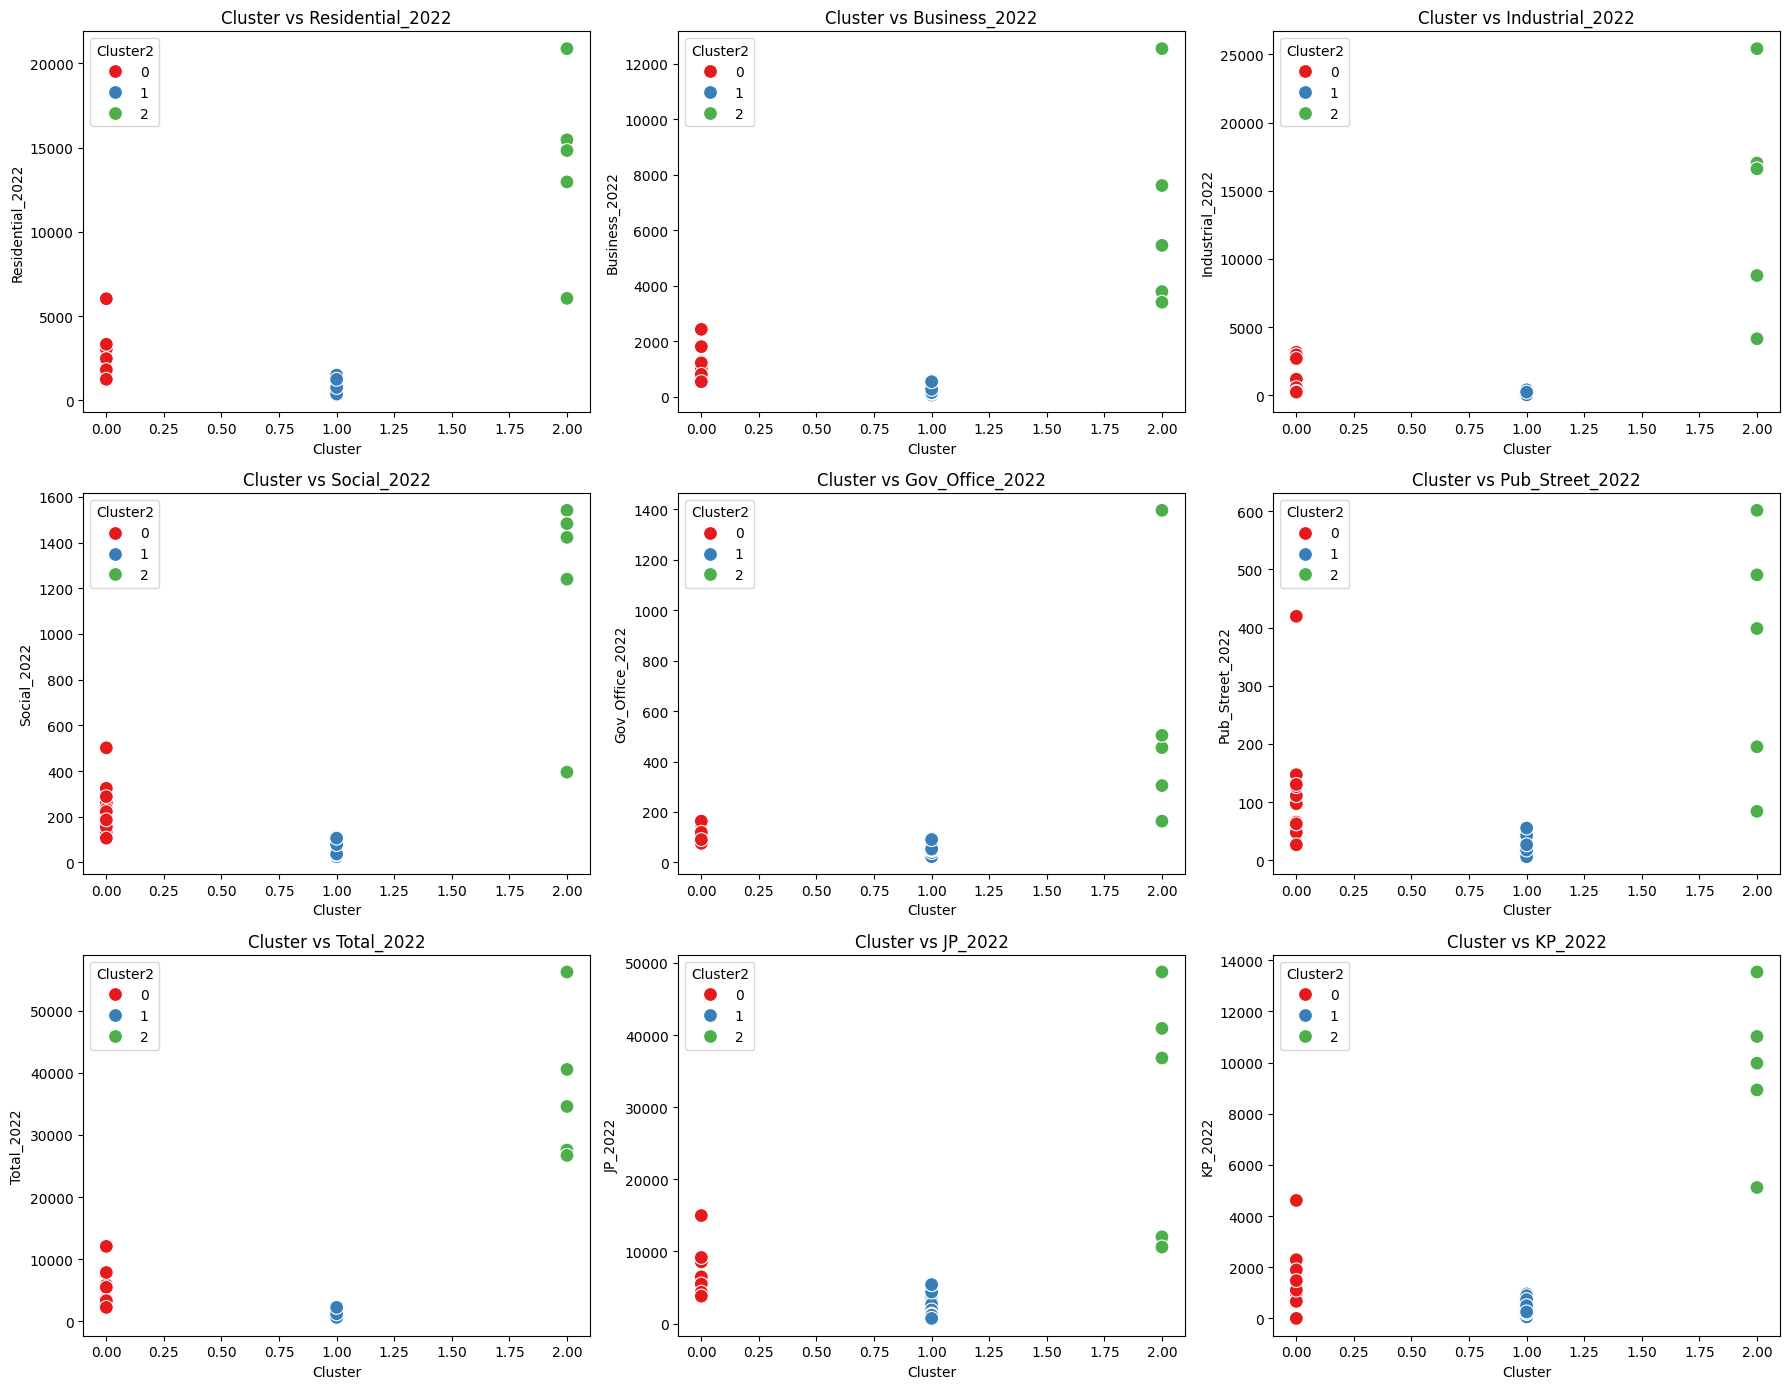

In [27]:
plt.figure(figsize=(18, 14))  

for i, feature in enumerate(features2, 1):
    plt.subplot(3, 3, i)  
    sns.scatterplot(x='Cluster2', y=feature, data=dataf, hue='Cluster2', palette='Set1', s=100)
    plt.title(f'Cluster vs {feature}')
    plt.xlabel('Cluster')
    plt.ylabel(f'{feature}')

plt.tight_layout()
plt.show()

In [28]:
features3 = ['Residential', 'Business', 'Industrial', 'Social', 'Gov_Office', 'Pub_Street', 'Total', 'JP_2023', 'KP_2023']

data_T2023 = dataf[features3]

scaler3 = RobustScaler()
scaled_features3 = scaler3.fit_transform(data_T2023)


k =3
medoid3 = np.random.choice(len(scaled_features3), size=k, replace=False)
medoids3 = scaled_features3[medoid3]

def update_medoids(dataf, medoids3):
    distances3 = pairwise_distances(dataf, medoids3)
    labels3 = np.argmin(distances3, axis=1)

    new_medoids3 = []
    for i in range(k):
        cluster_points3 = dataf[labels3 == i]
        intra_distances3 = pairwise_distances(cluster_points3)
        min_index3 = np.argmin(intra_distances3.sum(axis=1))
        new_medoids3.append(cluster_points3[min_index3])
    
    return np.array(new_medoids3), labels3

for _ in range(len(scaled_features3)):  
    new_medoids3, labels3 = update_medoids(scaled_features3, medoids3)
    if np.allclose(new_medoids3, medoids3):
        break
    medoids3 = new_medoids3

dataf['Cluster3'] = labels3

provinsi_per_cluster3 = dataf[['Province', 'Cluster3']].sort_values(by='Cluster3')


for cluster in range(k):  
    print(f"Provinsi dalam Cluster3 {cluster}:")
    print(provinsi_per_cluster3[provinsi_per_cluster3['Cluster3'] == cluster]['Province'].tolist())

    print(f"Nilai data point (medoid) untuk Cluster3 {cluster}:")
    print(medoids3[cluster])  
    print("\n")

Provinsi dalam Cluster3 0:
['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Sumatera Selatan', 'Kalimantan Selatan', 'Kalimantan Barat', 'Lampung', 'Bali', 'DI Yogyakarta', 'Sulawesi Selatan', 'Kalimantan Timur']
Nilai data point (medoid) untuk Cluster3 0:
[0.11743276 0.11103139 0.50527477 0.42241262 0.04186432 0.51795664
 0.25191506 0.34445486 0.16211199]


Provinsi dalam Cluster3 1:
['Kalimantan Tengah', 'Jambi', 'Kep. Riau', 'Bengkulu', 'Sulawesi Tengah', 'Gorontalo', 'Sulawesi Utara', 'Sulawesi Barat', 'Maluku', 'Maluku Utara', 'Papua', 'Sulawesi Tenggara', 'Papua Barat', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 'Kep. Bangka Belitung', 'Kalimantan Utara']
Nilai data point (medoid) untuk Cluster3 1:
[-0.28860304 -0.34658448 -0.19899601 -0.27331248 -0.47872901 -0.21950648
 -0.24235566 -0.384235   -0.38937539]


Provinsi dalam Cluster3 2:
['Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'DKI Jakarta', 'Banten']
Nilai data point (medoid) untuk Cluster3 2:
[ 6.0124565   5.18930831 

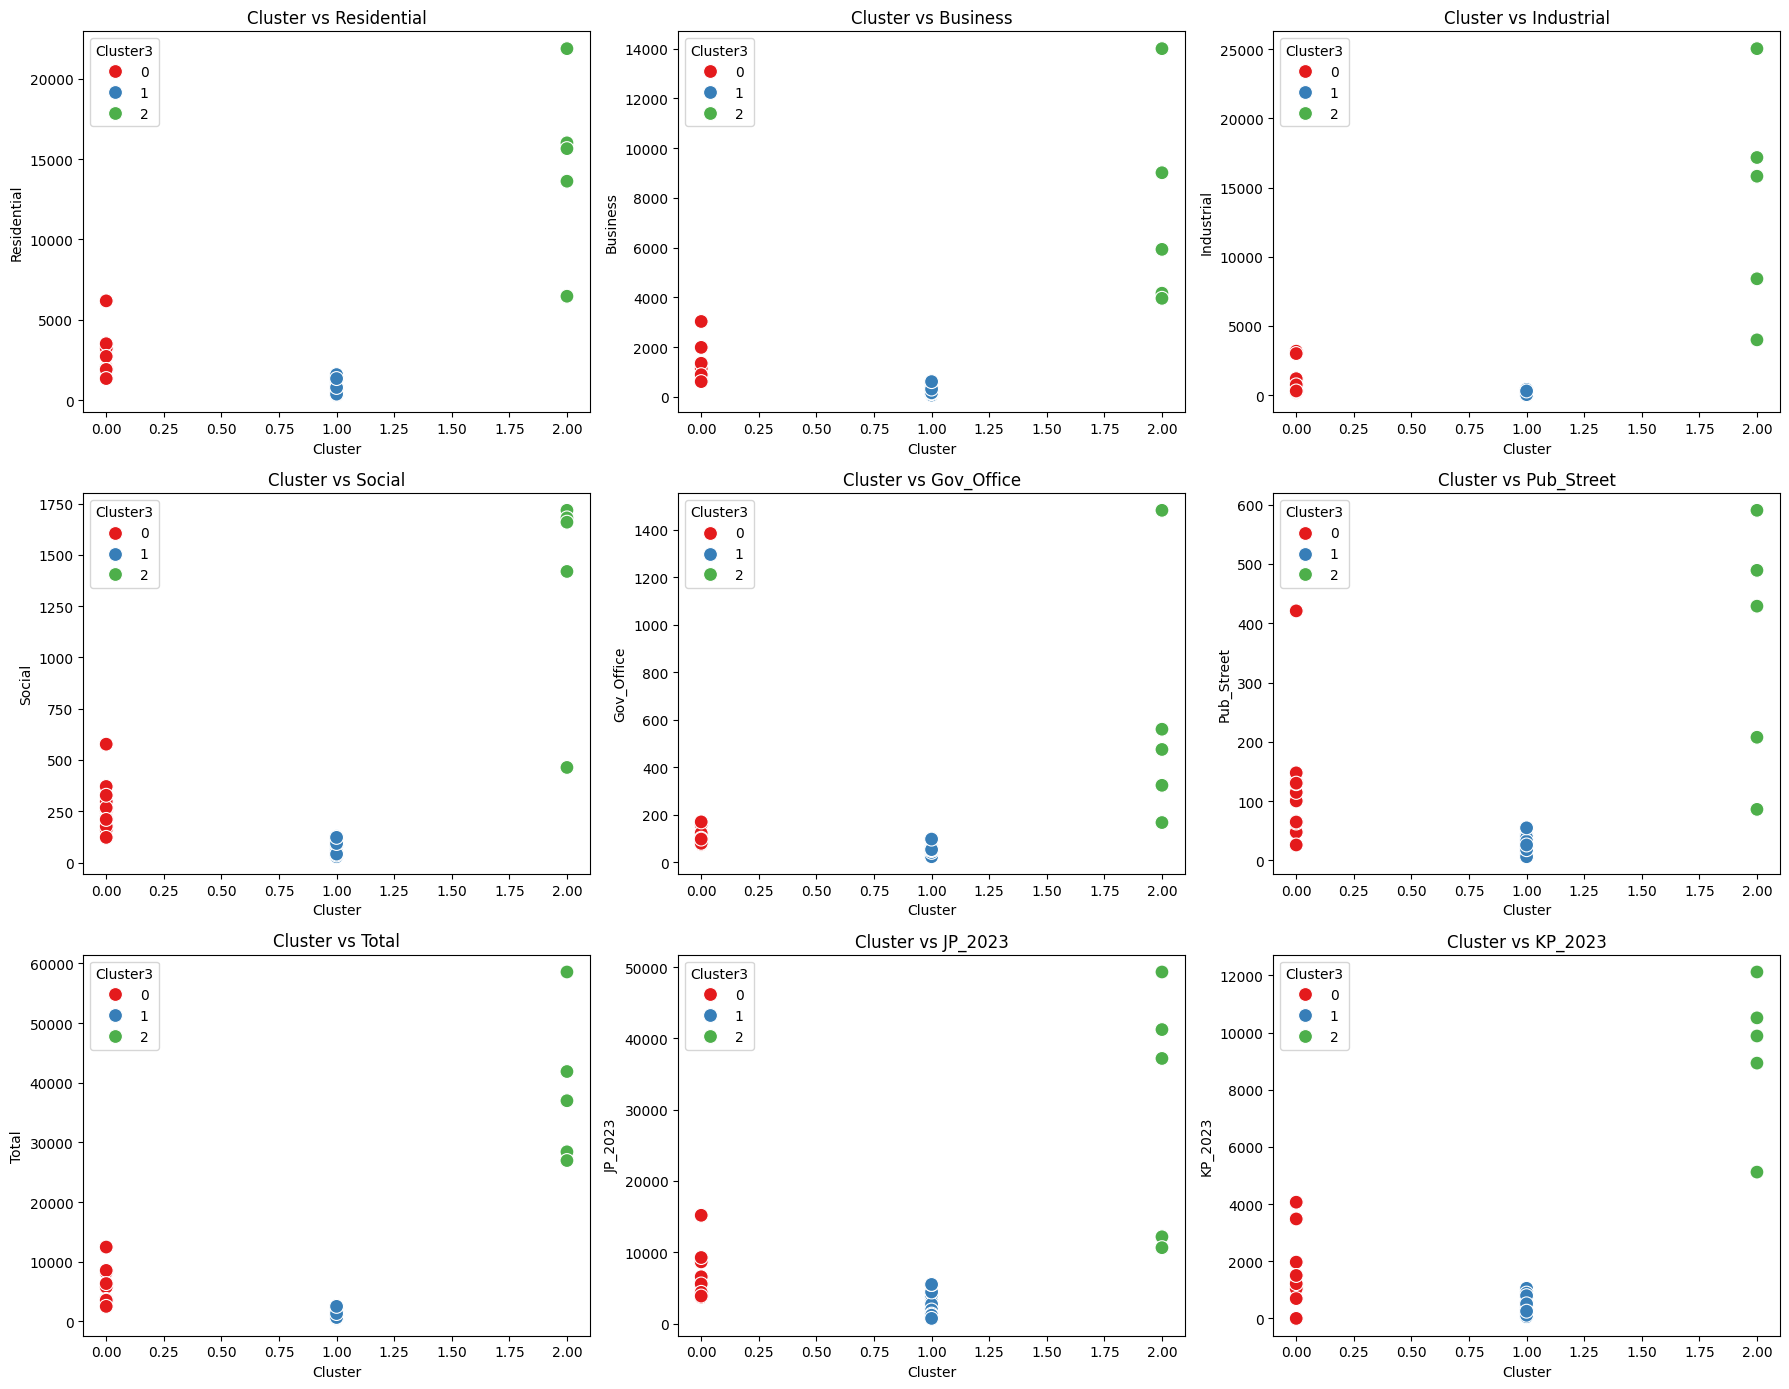

In [29]:
plt.figure(figsize=(18, 14))  

for i, feature in enumerate(features3, 1):
    plt.subplot(3, 3, i)  
    sns.scatterplot(x='Cluster3', y=feature, data=dataf, hue='Cluster3', palette='Set1', s=100)
    plt.title(f'Cluster vs {feature}')
    plt.xlabel('Cluster')
    plt.ylabel(f'{feature}')

plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import silhouette_score

sil_score_2021 = silhouette_score(scaled_features, dataf['Cluster'])
print(f"Silhouette Score untuk 2021: {sil_score_2021}")


sil_score_2022 = silhouette_score(scaled_features2, dataf['Cluster2'])
print(f"Silhouette Score untuk 2022: {sil_score_2022}")

sil_score_2023 = silhouette_score(scaled_features3, dataf['Cluster3'])
print(f"Silhouette Score untuk 2023: {sil_score_2023}")


Silhouette Score untuk 2021: 0.4028691248727197
Silhouette Score untuk 2022: 0.3797221288744153
Silhouette Score untuk 2023: 0.37437769089331907
